In [1]:
import sagemaker

# SageMaker Execution Role
# You can use sagemaker.get_execution_role() if running inside sagemaker's notebook instance
sagemaker_execution_role = sagemaker.get_execution_role() #Replace with ARN if not in an AWS SageMaker notebook

# paste the StepFunctionsWorkflowExecutionRole ARN from above
workflow_execution_role = 'arn:aws:iam::118600533013:role/StepFunctionsWorkflowExecutionRole'

In [2]:
%%sh
pip -q install --upgrade stepfunctions

In [3]:
import sys
from dateutil.parser import parse
import logging
import uuid
import stepfunctions
import json
import datetime
import os
import requests
import datetime
import time
import boto3
import s3fs
import pandas as pd
import numpy as np
from datetime import timedelta

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.transformer import Transformer
from stepfunctions import steps
from stepfunctions.steps import TrainingStep, ModelStep, TransformStep
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow
from stepfunctions.template import TrainingPipeline
from stepfunctions.template.utils import replace_parameters_with_jsonpath

sagemaker_session = sagemaker.Session()
stepfunctions.set_stream_logger(level=logging.INFO)

region = boto3.Session().region_name

s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "wind-notebook"  # prefix used for all data stored within the bucket

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [73]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [36]:
data = pd.read_csv('power_prd_0_19.csv', sep=",", index_col=0, parse_dates=True, decimal=",")
data.index.name = None

In [81]:
data = data.fillna(method='bfill')

In [123]:
data = data.asfreq(freq='1H')

In [124]:
for i in data.columns:
    data[i] = data[i].astype(float)

In [125]:
num_timeseries = data.shape[1]
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:, i], trim="f"))

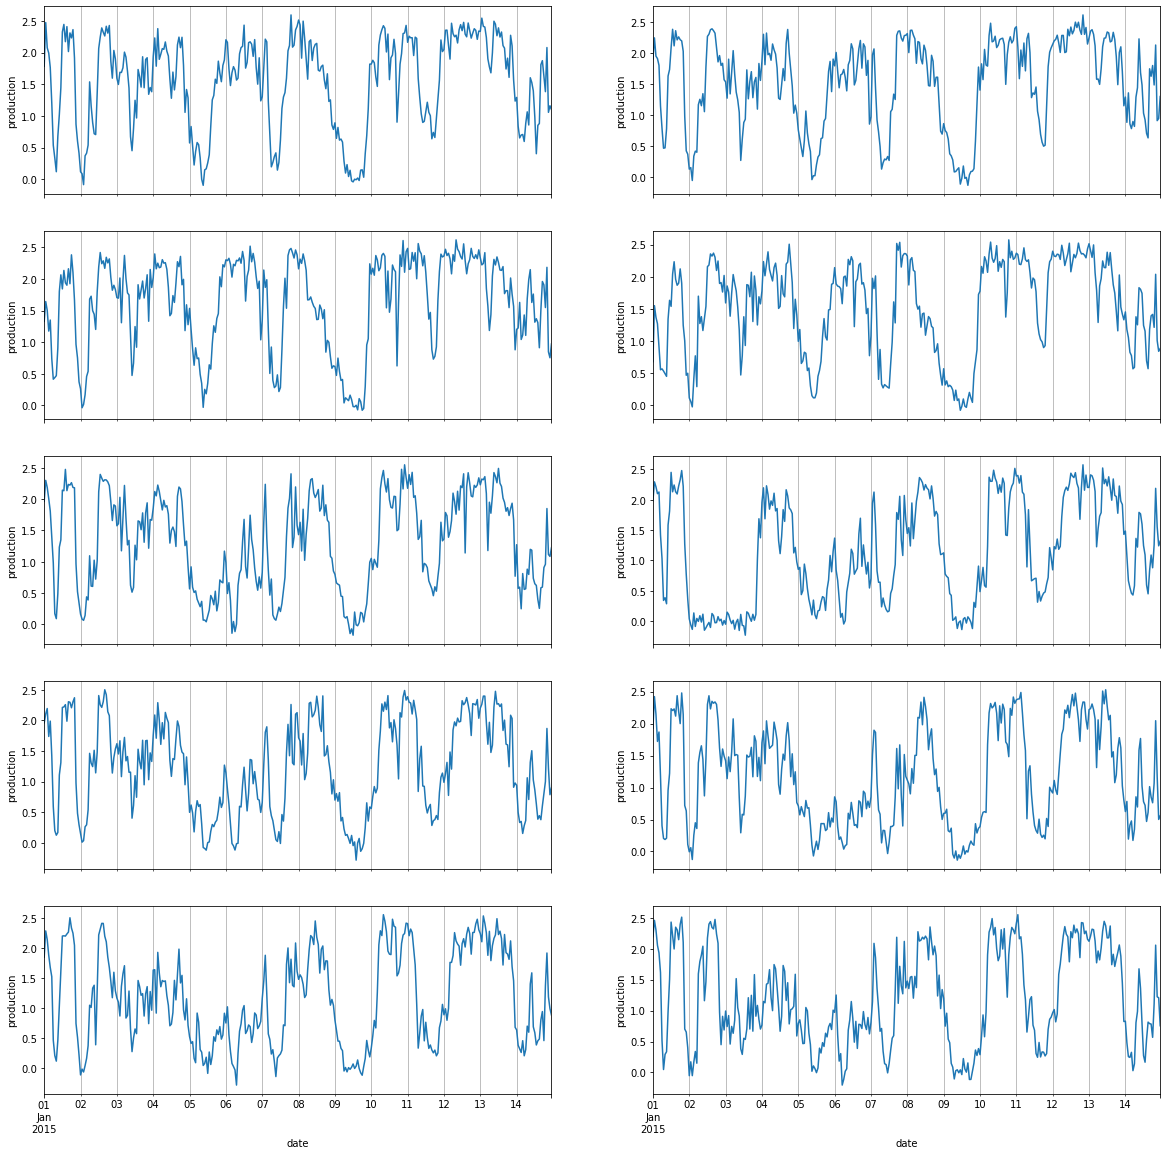

In [127]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2015-01-01":"2015-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("production")
    axx[i].grid(which="minor", axis="x")

Train and Test splits

In [142]:
# we use 1 hour frequency for the time series
freq = "1H"

# we predict for 5 days
prediction_length = 5*24

# we also use 5 days as context length, this is the number of state updates accomplished before making predictions
context_length = 5*24

We specify here the portion of the data that is used for training: the model sees data from 2015-01-01 to 2017-03-18 for training.

In [143]:
start_dataset = pd.Timestamp("2015-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2017-03-16 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (start) and a list of values (target). For more complex cases, DeepAR also supports the fields dynamic_feat for time-series features and cat for categorical features, which we will use later.

In [144]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

20


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 5 days, and comparing predictions with actual values.
To evaluate our model performance on more than 5 days, we generate test data that extends to 1, 2, 3, 4 times 5 days beyond the training range. This way we perform *rolling evaluation* of our model.

In [145]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

80


In [146]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [147]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 1.38 s, sys: 20.1 ms, total: 1.4 s
Wall time: 1.46 s


In [148]:
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [149]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-118600533013/wind-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-118600533013/wind-notebook/data/test/test.json
CPU times: user 183 ms, sys: 39.2 ms, total: 222 ms
Wall time: 597 ms


In [150]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[19][:100] + "...")

{"start": "2015-01-01 00:00:00", "target": [2.0780615048937627, 2.0123032944987576, 2.02550470208912...


Train a model

In [151]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=sagemaker_execution_role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-wind",
    output_path=s3_output_path,
)

In [171]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "300",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [172]:
estimator.set_hyperparameters(**hyperparameters)

In [170]:
# %%time
# data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

# estimator.fit(inputs=data_channels, wait=True)

Define the input schema for a workflow execution

The ExecutionInput API defines the options to dynamically pass information to a workflow at runtime.

The following cell defines the fields that must be passed to your workflow when starting an execution.

While the workflow is usually static after it is defined, you may want to pass values dynamically that are used by steps in your workflow. To help with this, the SDK provides a way to create placeholders when you define your workflow. These placeholders can be dynamically assigned values when you execute your workflow.

ExecutionInput values are accessible to each step of your workflow. You have the ability to define a schema for this placeholder collection, as shown in the cell below. When you execute your workflow the SDK will verify if the dynamic input conforms to the schema you defined.

In [157]:
# SageMaker expects unique names for each job, model and endpoint. 
# If these names are not unique the execution will fail. Pass these
# dynamically for each execution using placeholders.
execution_input = ExecutionInput(schema={
    'JobName': str, 
    'ModelName': str
})

Create the training step

In the following cell we create the training step and pass the estimator we defined above. See TrainingStep in the AWS Step Functions Data Science SDK documentation.

In [158]:
training_step = steps.TrainingStep(
    'Train Step', 
    estimator=estimator,
    data = {
        "train": "{}/train/".format(s3_data_path),
        "test": "{}/test/".format(s3_data_path)
    },
    job_name=execution_input['JobName']
)

Create the model step

In the following cell we define a model step that will create a model in SageMaker using the artifacts created during the TrainingStep. See ModelStep in the AWS Step Functions Data Science SDK documentation.

The model creation step typically follows the training step. The Step Functions SDK provides the get_expected_model method in the TrainingStep class to provide a reference for the trained model artifacts. Please note that this method is only useful when the ModelStep directly follows the TrainingStep.

In [159]:
model_step = steps.ModelStep(
    'Save model',
    model=training_step.get_expected_model(),
    model_name=execution_input['ModelName']  
)

Create the transform step

In the following cell we create the transform step. See TransformStep in the AWS Step Functions Data Science SDK documentation.

In [160]:
from sagemaker.predictor import json_serializer

transform_step = steps.TransformStep(
    'Transform Input Dataset',
    transformer=estimator.transformer(
        instance_count=1,
        instance_type='ml.m5.large',
        strategy='MultiRecord',
        output_path= '{}/batch-prediction'.format(s3_data_path),
        assemble_with='Line'
    ),
    job_name=execution_input['JobName'],     
    model_name=execution_input['ModelName'], 
    data='{}/test'.format(s3_data_path),
    split_type='Line'
)

Chain together steps for your workflow

Create your workflow definition by chaining the steps together. See Chain in the AWS Step Functions Data Science SDK documentation.

In [161]:
workflow_definition = steps.Chain([
    training_step,
    model_step,
    transform_step
])

Create your workflow using the workflow definition above, and render the graph with render_graph.

In [162]:
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

workflow = Workflow(
    name='{}-{}'.format('MyTrainTransformDeploy_v1', timestamp),
    definition=workflow_definition,
    role=workflow_execution_role,
    execution_input=execution_input
)

In [163]:
workflow.render_graph()

Create the workflow in AWS Step Functions with create.

In [164]:
workflow.create()

[INFO] Workflow created successfully on AWS Step Functions.


'arn:aws:states:us-east-1:118600533013:stateMachine:MyTrainTransformDeploy_v1-31-07-42-08'

In [165]:
execution = workflow.execute(
    inputs={
        'JobName': 'regression-{}'.format(uuid.uuid1().hex), # Each Sagemaker Job requires a unique name
        'ModelName': 'regression-{}'.format(uuid.uuid1().hex) # Each Model requires a unique name,
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


Render workflow progress with the render_progress.

This generates a snapshot of the current state of your workflow as it executes. This is a static image. Run the cell again to check progress.

In [166]:
execution.render_progress()

Use list_events to list all events in the workflow execution.

In [167]:
workflow.list_executions(html=True)

Name,Status,Started,End Time
b7f32816-b74d-4de2-966d-b845695acc58,RUNNING,"Mar 31, 2022 07:42:14.675 AM",-


In [168]:
template = workflow.get_cloudformation_template()

with open('workflow.json', 'w') as f:
    f.write(template)

[WARNING] To reuse the CloudFormation template in different regions, please make sure to update the region specific AWS resources in the StateMachine definition.


In [169]:
!cat workflow.json

AWSTemplateFormatVersion: '2010-09-09'
Description: CloudFormation template for AWS Step Functions - State Machine
Resources:
  StateMachineComponent:
    Type: AWS::StepFunctions::StateMachine
    Properties:
      StateMachineName: MyTrainTransformDeploy_v1-31-07-42-08
      DefinitionString: |-
        {
          "StartAt": "Train Step",
          "States": {
            "Train Step": {
              "Resource": "arn:aws:states:::sagemaker:createTrainingJob.sync",
              "Parameters": {
                "AlgorithmSpecification": {
                  "TrainingImage": "522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1",
                  "TrainingInputMode": "File"
                },
                "OutputDataConfig": {
                  "S3OutputPath": "s3://sagemaker-us-east-1-118600533013/wind-notebook/output"
                },
                "StoppingCondition": {
                  "MaxRuntimeInSeconds": 86400
                },
                "ResourceCo